In [1]:
import torch
import pandas as pd
import numpy as np

from torch import nn 

from torch.utils.data import DataLoader


import random
import os



from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from statannotations.Annotator import Annotator
import math
import time

import pickle

from src.utils.g2d_diff_genodrug_dataset import *
from src.utils.g2d_diff_geno_dataset import *

from src.g2d_diff_ce import *
from src.g2d_diff_diff import *
from src.g2d_diff_pred import *
#from src.g2dpred_rev import * # You can try this predictor from scratch


import sys
sys.path.insert(0, './vae_package')
sys.path.insert(0, './src')
from vae_package import vae_model, vae_lstm_model, vocab, vae_tool, pack_global, analysis_mp, vae_util, vae_eval, vae_lstm_tool, analysis



def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")



/home/jovyan/hyunho/anaconda3/envs/g2d_diff/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
torch.__version__

'1.11.0+cu113'

In [3]:
!python --version

Python 3.8.10


## Data Loading

In [5]:
PREDIFINED_GENOTYPES = ['mut', 'cna', 'cnd']

nci_data = pd.read_csv("data/drug_response_data/DC_drug_response.csv")
ev1_cells = ['HCT116_LARGE_INTESTINE',
                     'LOXIMVI_SKIN',
                     'K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
                     'MCF7_BREAST',
                     'CCRFCEM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE'
                      ]

ev2_cells = ['EKVX_LUNG', 'SKMEL28_SKIN', 'SKOV3_OVARY', 'NCIH226_LUNG', 'OVCAR4_OVARY']
ev3_cells = ['TK10_KIDNEY', 'OVCAR5_OVARY', 'HOP92_LUNG', 'SKMEL2_SKIN', 'HS578T_BREAST']


nci_data_train = nci_data[nci_data['ccle_name'].isin(ev1_cells)]
nci_data_val = nci_data[nci_data['ccle_name'].isin(ev2_cells)]
nci_data_test = nci_data[nci_data['ccle_name'].isin(ev3_cells)]



cell2mut = pd.read_csv("data/drug_response_data/original_cell2mut.csv", index_col = 0).rename(columns={'index':'ccle_name'})
cell2cna = pd.read_csv("data/drug_response_data/original_cell2cna.csv", index_col = 0).rename(columns={'index':'ccle_name'})
cell2cnd = pd.read_csv("data/drug_response_data/original_cell2cnd.csv", index_col = 0).rename(columns={'index':'ccle_name'})
drug2smi = pd.read_csv("data/drug_response_data/DC_drug2smi.csv").iloc[:, 0:-1]



geno_collate_fn = GenoCollator(genotypes=PREDIFINED_GENOTYPES)


genodrug_collate_fn = GenoDrugCollator(genotypes=PREDIFINED_GENOTYPES)

In [7]:
NUM_GEN = 1000
BATCH_SIZE = 100

## Model Loading

In [9]:
device='cuda:0'

diff_model = Diffusion(device = device, training=False).to(device).to(torch.float)



PREDICTOR = NCIPREDICTOR(num_of_genotypes = 3, num_of_dcls = 5, cond_dim = 128, drug_dim = 128,  device = device)



PREDICTOR.to(device).to(torch.float)



NeST neighbor info is used
Load pretrained cond_encoder ...
NeST neighbor info is used
Load pretrained cond_encoder ...


NCIPREDICTOR(
  (response_predictor): ResponsePredictor(
    (cond_enc): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): GELU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): GELU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=128, out_features=128, bias=True)
    )
    (drug_enc): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): GELU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): GELU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=128, out_features=128, bias=True)
    )
    (downsampler): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): GELU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): GELU()
      (5): Dropout(p

## Chemical VAE Loading

In [12]:
vo = vocab.Vocabulary(init_from_file='data/chemicalVAE_tokens.txt')
smtk = vocab.SmilesTokenizer(vo)
rvae20 = vae_lstm_model.RNNVAE(vo, smtk, device=device, load_fn='data/model_ckpts/250_lstm09.ckpt') 
rvae20.model.eval()


sampler = vae_tool.RNNVAESampler(rvae20, vo, batch_size=BATCH_SIZE) 

## Generation & Decoding

w:  7
NeST neighbor info is used
Load pretrained cond_encoder ...
Generatation Start
Cell Name:  HCT116_LARGE_INTESTINE, Res Class:  0
 Generation Done. Took 126.49599 sec
Generatation Start
Cell Name:  HCT116_LARGE_INTESTINE, Res Class:  1
 Generation Done. Took 125.81246 sec
Generatation Start
Cell Name:  HCT116_LARGE_INTESTINE, Res Class:  2
 Generation Done. Took 129.70390 sec
Generatation Start
Cell Name:  HCT116_LARGE_INTESTINE, Res Class:  3
 Generation Done. Took 129.37102 sec
Generatation Start
Cell Name:  HCT116_LARGE_INTESTINE, Res Class:  4
 Generation Done. Took 127.09682 sec
Decode Start
 Decode Done. Took 7.67874 sec
Cell line:  HCT116_LARGE_INTESTINE, Res Class:  0
Val:  0.851, Unq:  0.6886016451233843, Nvl:  0.9931740614334471, Div:  0.8394646461776665, FCD:  14.479712692132182
Decode Start
 Decode Done. Took 7.22837 sec
Cell line:  HCT116_LARGE_INTESTINE, Res Class:  1
Val:  0.622, Unq:  1.0, Nvl:  1.0, Div:  0.8772010585583663, FCD:  10.842725223928767
Decode Start
 

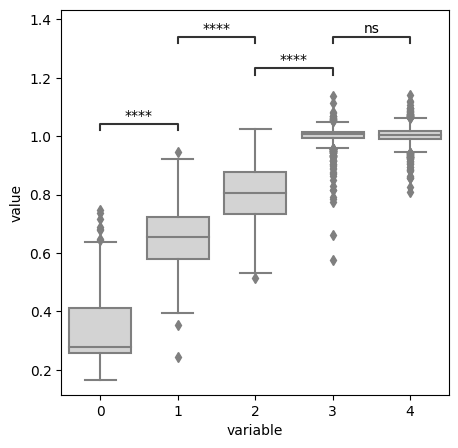

In [29]:

cfgw = 7
input_cells = ev1_cells
print("w: ", cfgw)

diff_model = Diffusion(device = device, training=False, cfgw = cfgw).to(device).to(torch.float)
prev_ckpt = torch.load("data/model_ckpts/1229_512_adanorm_6layers_2474.ckpt", map_location=device)
diff_model.load_state_dict(prev_ckpt['diffusion_state_dict'])
diff_model.eval()

## Generate input dataframe for batch generation

all_dfs = {}
generation_df = pd.DataFrame(columns =['ccle_name', 'NSC', 'SMILES', 'auc'])
for cell in input_cells:
    for i in range(5):
        all_dfs[(cell, i)] = []
        for j in range(NUM_GEN):
            all_dfs[(cell, i)].append(pd.DataFrame(data = np.array([(cell, i)]), columns = ['ccle_name', 'auc_label']).astype({'auc_label' : 'int64'}))
        all_dfs[(cell, i)] = pd.concat(all_dfs[(cell, i)])

gen_dicts = {}
basic_perfom = {}

## Generation Start for each cell in input cell list and each condition i (0-4, vsen to vres)

for cell in input_cells:
    for i in range(5):
        print("Generatation Start")
        start = time.time()
        print("Cell Name: ", cell, end=", ")
        print("Res Class: ", i)
        dataset_obj = GenoDataset(all_dfs[(cell, i)], cell2mut, cna=cell2cna, cnd=cell2cnd)
        tra_loader = DataLoader(dataset_obj, batch_size=BATCH_SIZE, drop_last=False,  collate_fn=geno_collate_fn)

        gen_list = []

        for t in range(1):
            for _, batch in enumerate(tra_loader):
                
                for key in batch.keys():
                    if 'genotype' in key:
                        for mut in batch[key].keys():
                            batch[key][mut] = batch[key][mut].to(device)
                    elif key == 'cell_name':
                        None
                    else:
                        batch[key] = batch[key].to(device)


                noise = torch.randn(BATCH_SIZE, 128).to(device)

                drugs, _ = diff_model.p_sample_loop(batch, noise) 




                gen_list.append(drugs.detach().cpu().numpy())

        gen_npy = np.vstack(gen_list)
        gen_dicts[(cell, i)] = gen_npy
        end = time.time()
        print(f" Generation Done. Took {end - start:.5f} sec")



data_df = pd.DataFrame(columns = nci_data.columns)
drug_df = pd.DataFrame(columns = drug2smi.columns)


## Decode the generated vectors into SMILES using Chemical VAE

auc_dict = {0:0.3, 1:0.5, 2:0.7, 3:0.9, 4:1.1}

for key in gen_dicts.keys():
    cell_name, i = key
    print("Decode Start")
    start = time.time()
    return_smiles = sampler.gen_to_smiles(sampler.sample_from_z(gen_dicts[key], method='greedy').detach().cpu().numpy())
    end = time.time()
    print(f" Decode Done. Took {end - start:.5f} sec")


    vacans, invids = analysis_mp.get_valid_canons(return_smiles)
    all_index = np.arange(0, NUM_GEN, 1)
    valid_vec = gen_dicts[key][~np.isin(all_index, invids)]
    vld, unq, nvl = analysis_mp.evaluation_basic(len(return_smiles), vacans, drug2smi['canonical_smiles'].values)

    vacans_fps = analysis.get_fps_from_smilist(vacans)
    _simmat = analysis.calculate_simmat(vacans_fps, vacans_fps)
    div = analysis.internal_diversity(_simmat)
    _gt_set = nci_data[nci_data['ccle_name']==cell_name]
    gt_set_drugid = list(_gt_set[_gt_set['auc_label']==i]['drug'].unique())
    gt_set_drug_smiles = drug2smi[drug2smi['drug'].isin(gt_set_drugid)]['canonical_smiles'].values
    fcd = analysis.fcd_calculation(list(vacans), list(gt_set_drug_smiles))



    for j, smi in enumerate(vacans):
        generation_df.loc[len(generation_df)] = {'ccle_name':cell_name, 'NSC':cell_name+"_"+str(i)+"_"+str(j), 'SMILES':smi, 'auc':auc_dict[i]}
    
    basic_perfom[key] = (vld, unq, nvl, div, fcd)
    print("Cell line: ", cell_name, end=", ")
    print("Res Class: ", i)
    print("Val: ", vld, end=", ")
    print("Unq: ", unq, end=", ")
    print("Nvl: ", nvl, end=", ")
    print("Div: ", div, end=", ")
    print("FCD: ", fcd)

    num_drugs = len(vacans)
    _drug_df = pd.DataFrame(columns = drug2smi.columns)[['drug', 'canonical_smiles']]
    _data_df = pd.DataFrame(columns = nci_data.columns)
    for j in range(num_drugs):
        _drug_df.loc[j] = (cell_name+"_"+str(i)+"_"+str(j), vacans[j])
        _data_df.loc[j] = (cell_name, cell_name+"_"+str(i)+"_"+str(j), auc_dict[i], i)

    feature_df = pd.DataFrame(valid_vec)
    _drug_df = pd.concat([_drug_df, feature_df], axis = 1)
    _drug_df.columns = _drug_df.columns.astype(str)
    data_df = pd.concat([data_df, _data_df], axis = 0)
    drug_df = pd.concat([drug_df, _drug_df], axis = 0)

## Predict the AUC of the generated compound using G2D-Pred

prediction_dataset = GenoDrugDataset(data_df, cell2mut, drug_df, cna=cell2cna, cnd=cell2cnd)
all_pred_res = []

for ii, nckpt in enumerate([194, 191, 198, 185, 191]):
    prev_ckpt = torch.load("data/model_ckpts/0104_predictor_"+str(ii)+"_"+str(nckpt)+".pth", map_location=device)
    PREDICTOR.load_state_dict(prev_ckpt['predictor_state_dict'])
## If you try to use the predictor from scratch, use below model checkpoints.
##for ii, nckpt in enumerate([198, 191, 198, 198, 193]):
##       prev_ckpt = torch.load("data/model_ckpts/250324_predictor_"+str(ii)+"_"+str(nckpt)+".pth", map_location=device)
##       PREDICTOR.load_state_dict(prev_ckpt['predictor_state_dict'])
    PREDICTOR.eval()
    tr_loader = DataLoader(prediction_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=genodrug_collate_fn)
    pred_list = []
    targ_list = []

    for i, batch in enumerate(tr_loader):


        ## Batch data load to device
        for key in batch.keys():
            if 'genotype' in key:
                for mut in batch[key].keys():
                    batch[key][mut] = batch[key][mut].to(device)
            elif key == 'cell_name':
                None
            elif key == 'drug_name':
                None
            else:
                batch[key] = batch[key].to(device)


        pred_auc = PREDICTOR(batch)

        pred_list.append(pred_auc.squeeze().detach().cpu().numpy())
        targ_list.append(batch['auc'].detach().cpu().numpy())
    pred_list = np.hstack(pred_list)
    targ_list = np.hstack(targ_list) 
    all_pred_res.append(pred_list)


## Result visualization

all_pred_res = np.vstack(all_pred_res).mean(axis = 0)    


vsen = pd.DataFrame(all_pred_res[targ_list==0.3])
sen = pd.DataFrame(all_pred_res[targ_list==0.5])
mod = pd.DataFrame(all_pred_res[targ_list==0.7])
res = pd.DataFrame(all_pred_res[targ_list==0.9])
vres = pd.DataFrame(all_pred_res[targ_list==1.1])
x = [vsen, sen, mod, res, vres]
result = pd.concat(x, ignore_index=True, axis = 1)
result = result.melt().dropna()

## variable: Response Class, value: Predicted AUC 

result['variable'] = result['variable'].astype('str')

plt.figure(figsize=(5,5))
ax = sns.boxplot(data=result, x = 'variable', y='value', color = 'lightgray')

pairs=[("0", "1"), ("2", "3"), ("1", "2"), ("3", "4")]
annotator = Annotator(ax, pairs, data=result, x='variable', y='value')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

plt.show()

## Result save to file

data_df['predicted_auc'] = all_pred_res
data_df = pd.merge(data_df, drug_df[['drug', 'canonical_smiles']], on='drug')[['ccle_name', 'auc_label', 'canonical_smiles', 'predicted_auc']]
data_df.to_csv("Generated_sample.csv", index=False)

